In [1]:
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns;sns.set_style('whitegrid',{'grid.color':'0.95'})
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tabulate import tabulate
from matplotlib import gridspec
from matplotlib.dates import DateFormatter
from scipy import stats
from linearmodels.iv import IV2SLS
from linearmodels.iv import compare
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF
from arch.unitroot import DFGLS
from arch.unitroot import PhillipsPerron
from lmfit import minimize, Parameters, report_fit

In [2]:
poe5csv='http://www.principlesofeconometrics.com/poe5/data/csv/'
gdp=pd.read_csv(poe5csv+'gdp5.csv')
print('First 5 data rows of the GDP DataFrame')
print(gdp.head(),'\n')
print('Last 5 data rows of the GDP DataFrame')
print(gdp.tail(),'\n')
print('GDP DataFrame column data types')
print(gdp.dtypes)

First 5 data rows of the GDP DataFrame
    dateid01     gdp
0   1/1/1984  7.1406
1   4/1/1984  7.2660
2   7/1/1984  7.3375
3  10/1/1984  7.3960
4   1/1/1985  7.4695 

Last 5 data rows of the GDP DataFrame
      dateid01      gdp
127  10/1/2015  16.4907
128   1/1/2016  16.5250
129   4/1/2016  16.5831
130   7/1/2016  16.7270
131  10/1/2016  16.8048 

GDP DataFrame column data types
dateid01     object
gdp         float64
dtype: object


In [3]:
gdp['dateid01']=pd.to_datetime(arg=gdp.dateid01,format='%m/%d/%Y' )
print('DATEID01 Data Type:')
print(gdp.dtypes)

DATEID01 Data Type:
dateid01    datetime64[ns]
gdp                float64
dtype: object


In [4]:
gdp['qtr']=pd.PeriodIndex(data=gdp.dateid01,freq='Q')
gdp=gdp.set_index(gdp.qtr)
print('QTR Data Type:')
print(gdp.dtypes,'\n')
print('First 5 DataFrame rows with QTR set as index:')
print(gdp.head())

QTR Data Type:
dateid01    datetime64[ns]
gdp                float64
qtr          period[Q-DEC]
dtype: object 

First 5 DataFrame rows with QTR set as index:
         dateid01     gdp     qtr
qtr                              
1984Q1 1984-01-01  7.1406  1984Q1
1984Q2 1984-04-01  7.2660  1984Q2
1984Q3 1984-07-01  7.3375  1984Q3
1984Q4 1984-10-01  7.3960  1984Q4
1985Q1 1985-01-01  7.4695  1985Q1


In [5]:
gdp['year']=gdp.dateid01.dt.year
gdp['quarter']=gdp.dateid01.dt.quarter
n=len(gdp.index)
s=[]
for i in range(n):
    val1=str(gdp.iloc[i,3])+'Q'+str(gdp.iloc[i,4])
    s.append(val1)
gdp['qtr_str']=s
gdp=gdp.set_index(gdp.qtr_str)
print('QTR Data Type:')
print(gdp.dtypes,'\n')
print('First 3 DataFrame rows with QTR set as index:')
print(gdp.head(3))  

QTR Data Type:
dateid01    datetime64[ns]
gdp                float64
qtr          period[Q-DEC]
year                 int32
quarter              int32
qtr_str             object
dtype: object 

First 3 DataFrame rows with QTR set as index:
          dateid01     gdp     qtr  year  quarter qtr_str
qtr_str                                                  
1984Q1  1984-01-01  7.1406  1984Q1  1984        1  1984Q1
1984Q2  1984-04-01  7.2660  1984Q2  1984        2  1984Q2
1984Q3  1984-07-01  7.3375  1984Q3  1984        3  1984Q3


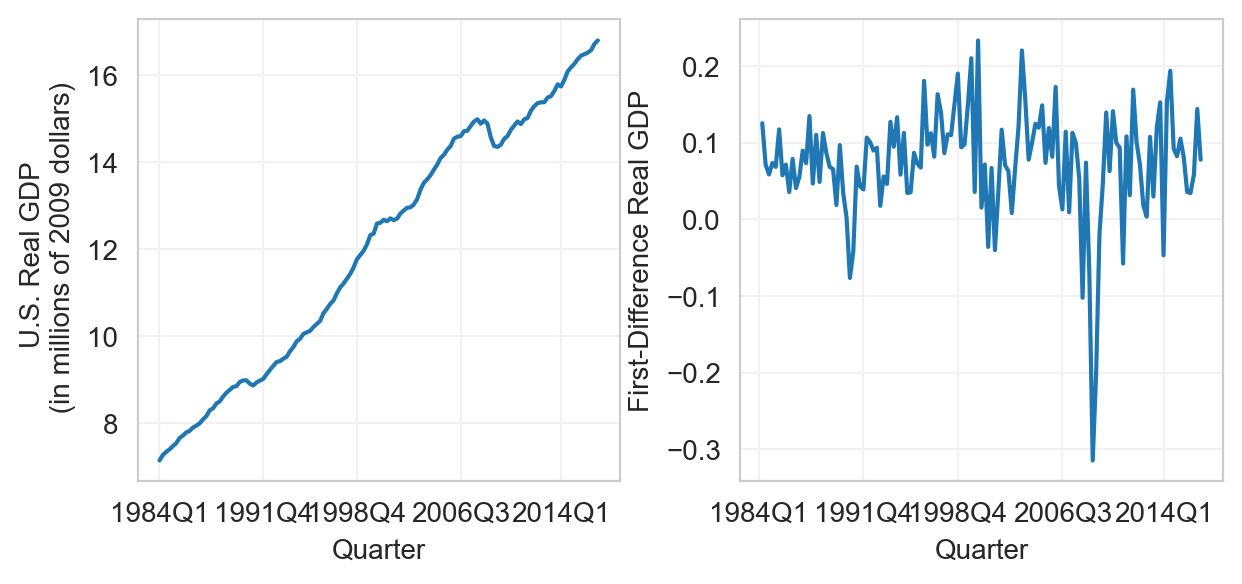

In [6]:
gdp['D1gdp']=gdp.gdp.diff(1)
gdp=gdp[['gdp','D1gdp']]
l=['U.S. Real GDP \n (in millions of 2009 dollars)'
   ,'First-Difference Real GDP']
fig=plt.figure(figsize=(7,3))
fig.subplots_adjust(wspace=0.25)
for i in range(0,2):
    ax=fig.add_subplot(1,2,i+1)
    ax=sns.lineplot(x=gdp.index,y=gdp.iloc[:,i])
    ax.set(xlabel='Quarter',ylabel=l[i])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

In [7]:
usdat=pd.read_csv(poe5csv+'usdata5.csv',parse_dates=['dateid01'])
usdat['date']=usdat['dateid01'].dt.strftime('%m/%y')
usdat=usdat.set_index('date')
print('Monthly Summary Statistics:')
print(usdat[['br','ffr','infn']].describe(percentiles=[]).transpose())
usdat['D1infn']=usdat['infn'].diff(1)
usdat['D1ffr']=usdat['ffr'].diff(1)
usdat['D1br']=usdat['br'].diff(1)

Monthly Summary Statistics:
      count      mean       std     min     50%     max
br    749.0  5.427810  3.151571  0.3300  5.2000  16.220
ffr   749.0  4.927850  3.608799  0.0700  4.7300  19.100
infn  749.0  3.506025  2.705815 -1.9782  2.9488  13.621


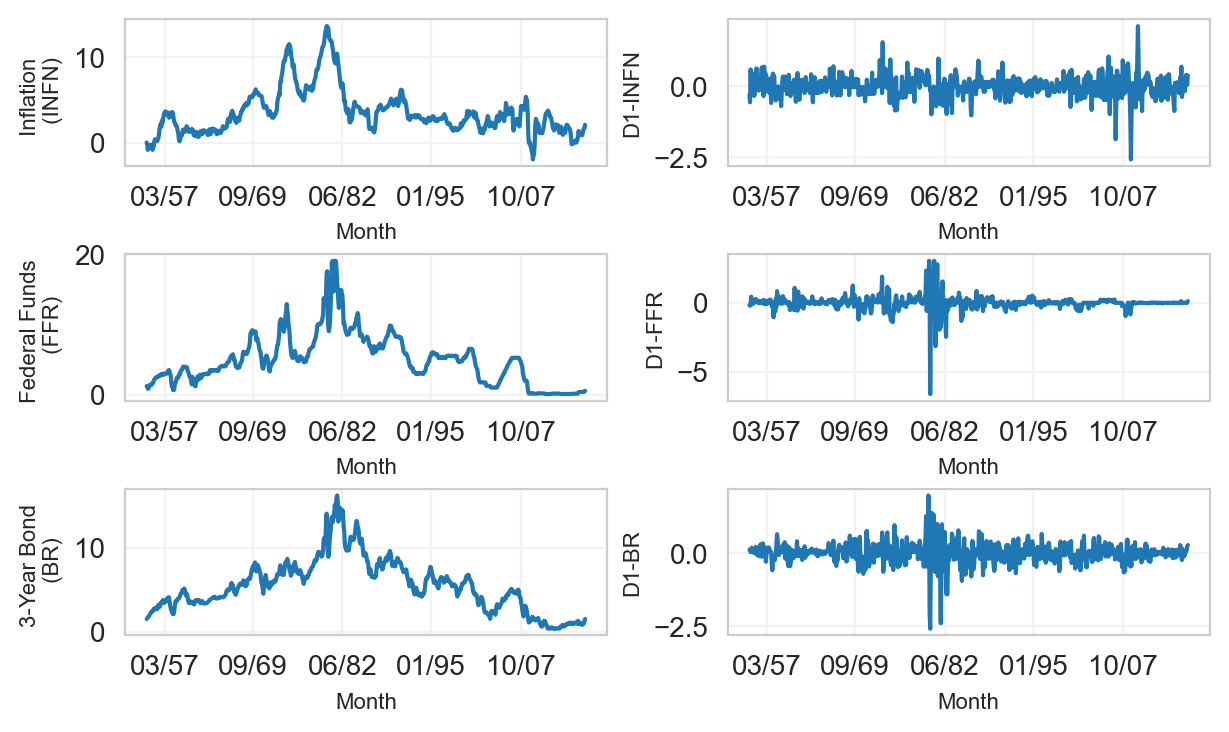

In [8]:
usdat_gr=usdat[['infn','D1infn','ffr','D1ffr','br','D1br']]
l=['Inflation \n (INFN)','D1-INFN'
   ,'Federal Funds \n (FFR)','D1-FFR','3-Year Bond \n (BR)'
   ,'D1-BR']
fig=plt.figure(figsize=(7,4))
for i in range(0,6):
    ax=fig.add_subplot(3,2,i+1)
    fig.subplots_adjust(hspace=0.6,wspace=0.25)
    ax=sns.lineplot(x=usdat_gr.index,y=usdat_gr.iloc[:,i])
    ax.set(xlabel='Month',ylabel=l[i])
    ax.yaxis.label.set_size(8)
    ax.xaxis.label.set_size(8)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))

In [9]:
print('Monthly Summary Statistics before 2000Q4:')
print(gdp[gdp.index<='2000Q3'][['gdp','D1gdp']].describe(percentiles=[]).transpose(),'\n')
print('Monthly Summary Statistics after 2000Q3:')
print(gdp[gdp.index>'2000Q3'][['gdp','D1gdp']].describe(percentiles=[]).transpose())

Monthly Summary Statistics before 2000Q4:
       count      mean       std     min     50%      max
gdp     67.0  9.521281  1.500158  7.1406  9.2235  12.6077
D1gdp   66.0  0.082835  0.052875 -0.0765  0.0803   0.2334 

Monthly Summary Statistics after 2000Q3:
       count       mean       std      min      50%      max
gdp     65.0  14.682274  1.158818  12.6433  14.7459  16.8048
D1gdp   65.0   0.064571  0.087217  -0.3146   0.0778   0.2203


In [10]:
print('Montly Summary Statistics between 1954-08-01 and 1985-10-01:')
print(usdat[(usdat.dateid01>='1954-08-01')&(usdat.dateid01<='1985-10-01')]
      [['br','ffr','infn','D1infn','D1ffr','D1br']]
      .describe(percentiles=[]).transpose())

Montly Summary Statistics between 1954-08-01 and 1985-10-01:
        count      mean       std     min      50%      max
br      375.0  6.561760  3.235801  1.4900  5.88000  16.2200
ffr     375.0  6.202560  3.876930  0.6300  5.06000  19.1000
infn    375.0  4.416266  3.349849 -0.8574  3.55230  13.6210
D1infn  374.0  0.008513  0.334884 -0.9808 -0.00975   1.5549
D1ffr   374.0  0.018102  0.692730 -6.6300  0.03000   3.0600
D1br    374.0  0.020749  0.422955 -2.5800  0.05000   1.9600


In [11]:
print('Montly Summary Statistics between 1985-10-01 and 2016-12-01:')
print(usdat[(usdat.dateid01>='1985-11-01')&(usdat.dateid01<='2016-12-01')]
      [['br','ffr','infn','D1infn','D1ffr','D1br']]
      .describe(percentiles=[]).transpose())

Montly Summary Statistics between 1985-10-01 and 2016-12-01:
        count      mean       std     min      50%     max
br      374.0  4.290829  2.613551  0.3300  4.55500  9.6100
ffr     374.0  3.649733  2.788233  0.0700  3.99000  9.8500
infn    374.0  2.593350  1.327540 -1.9782  2.66015  6.1844
D1infn  374.0 -0.002978  0.385026 -2.5692 -0.00650  2.1207
D1ffr   374.0 -0.019920  0.196880 -0.9600  0.00000  0.8700
D1br    374.0 -0.020749  0.257154 -0.8000 -0.03000  0.7400


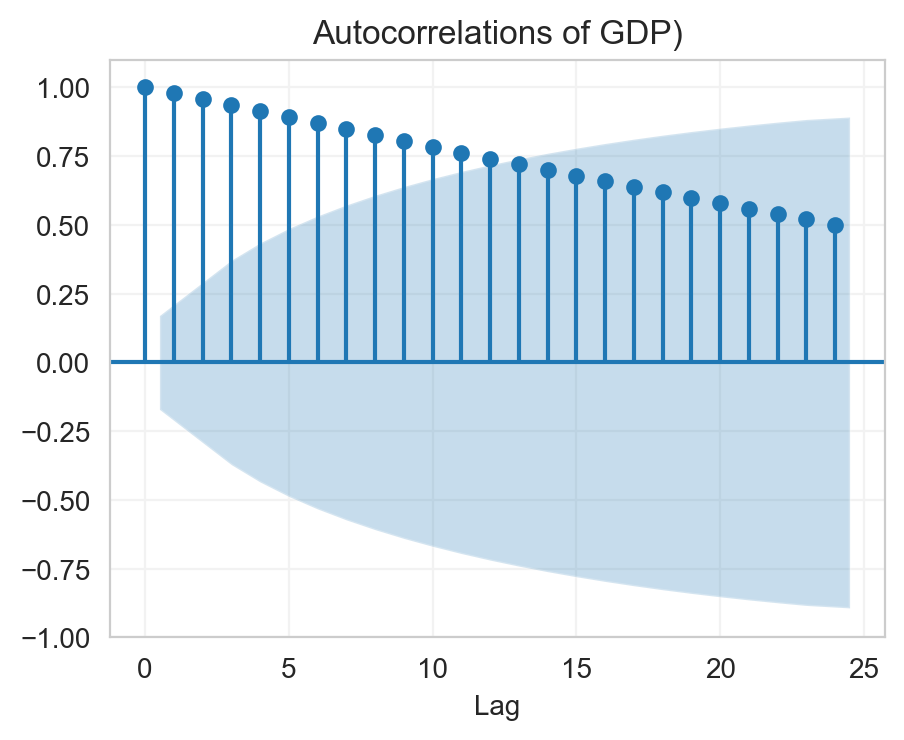

In [12]:
ax2=sm.graphics.tsa.plot_acf(gdp['gdp'],lags=24,title='Autocorrelations of GDP)')  
plt.ylim((-1,1.1))
plt.xlabel('Lag');

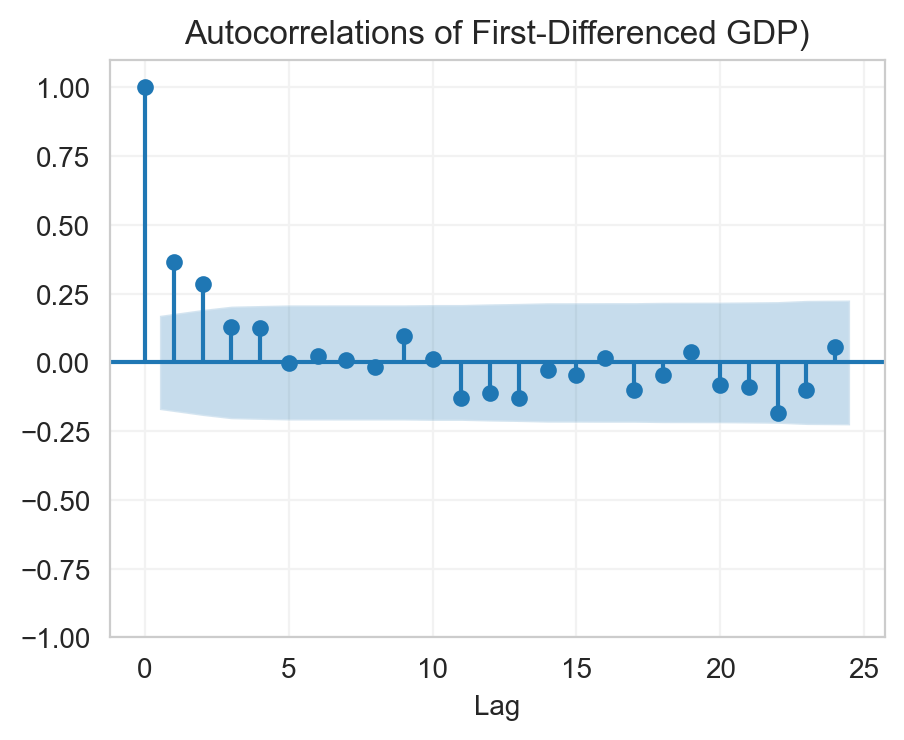

In [13]:
gdp=gdp.dropna()
ax2=sm.graphics.tsa.plot_acf(gdp['D1gdp'],lags=24,
                             title='Autocorrelations of First-Differenced GDP)')  
plt.ylim((-1,1.1))
plt.xlabel('Lag');

In [14]:
tood=pd.read_csv(poe5csv+'toody5.csv')
tood['dateid01']=pd.to_datetime(tood['dateid01'],format='%m/%d/%Y' )
tood=tood.set_index('year')
tood['lny']=np.log(tood.y)
print(tood.head(3))

       dateid01   rain  t  trend       y       lny
year                                              
1950 1950-01-01  4.099  1    0.0  1.3508  0.300697
1951 1951-01-01  3.574  2    0.1  0.9476 -0.053823
1952 1952-01-01  4.258  3    0.2  1.2569  0.228648


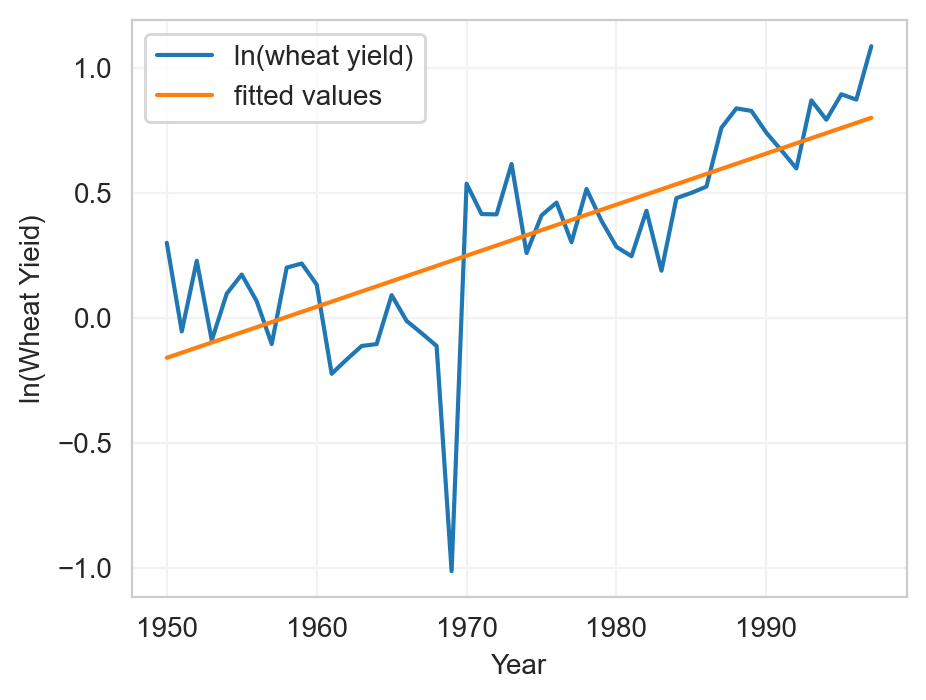

In [15]:
res=smf.ols(formula='lny~tood.index',data=tood).fit()
tood['lnyhat']=res.predict()
ax=sns.lineplot(x=tood.index,y=tood.lny,label='ln(wheat yield)')
plt.plot(tood.index,res.predict(),color='tab:orange',label='fitted values')
ax.set(xlabel='Year',ylabel='ln(Wheat Yieid)')
plt.legend();

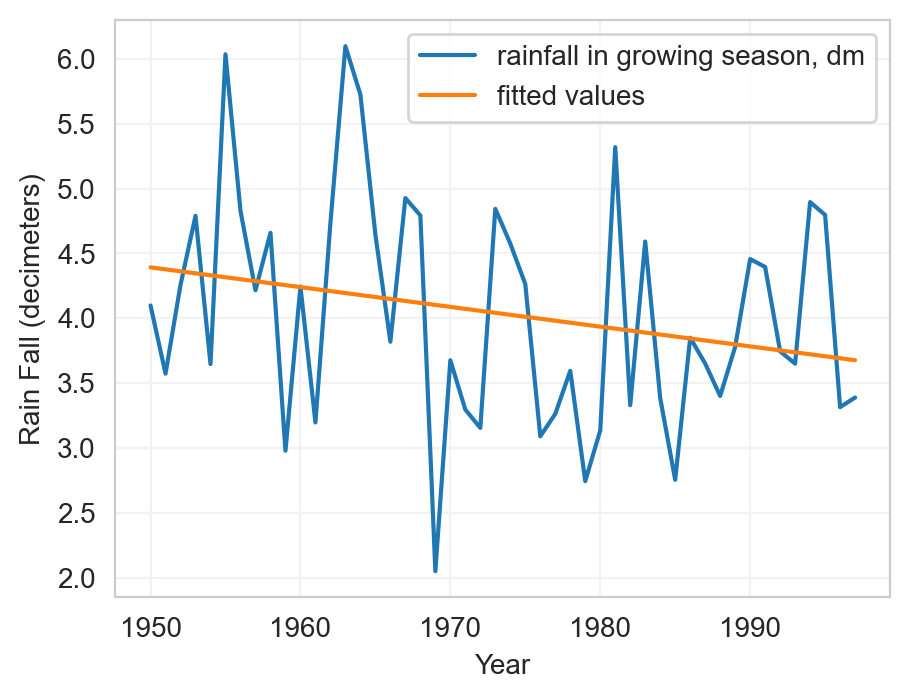

In [16]:
res=smf.ols(formula='rain~tood.index',data=tood).fit()
tood['rain_hat']=res.predict()
ax=sns.lineplot(x=tood.index,y=tood.rain,label='rainfall in growing season, dm')
plt.plot(tood.index,res.predict(),color='tab:orange',label='fitted values')
ax.set(xlabel='Year',ylabel='Rain Fall (decimeters)')
plt.legend();

In [17]:
tood['rain2']=tood.rain**2
res=smf.ols(formula='lny~t+rain+rain2',data=tood).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5101      0.594     -4.223      0.000      -3.708      -1.312
t              0.0197      0.003      7.822      0.000       0.015       0.025
rain           1.1490      0.290      3.957      0.000       0.564       1.734
rain2         -0.1344      0.035     -3.883      0.000      -0.204      -0.065


In [18]:
res=smf.ols(formula='lny~t',data=tood).fit()
tood['e_lny']=res.resid
res=smf.ols(formula='rain~t',data=tood).fit()
tood['e_rain']=res.resid
res=smf.ols(formula='rain2~t',data=tood).fit()
tood['e_rain2']=res.resid
res=smf.ols(formula='e_lny~e_rain+e_rain2-1',data=tood).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
e_rain         1.1490      0.284      4.046      0.000       0.577       1.721
e_rain2       -0.1344      0.034     -3.970      0.000      -0.203      -0.066


In [19]:
res=smf.ols('lny~t+rain+rain2',data=tood).fit()
se_rain=res.bse['rain']
res=smf.ols(formula='e_lny~e_rain+e_rain2-1',data=tood).fit()
se_e_rain=np.sqrt(46/44)*res.bse['e_rain']
print(f'se_rain   = {se_rain:.8f}')
print(f'se_e_rain = {se_e_rain:.8f}')

se_rain   = 0.29035553
se_e_rain = 0.29035553


In [20]:
spur=pd.read_csv(poe5csv+'spurious.csv')
spur['time']=np.arange(0,700)
spur=spur.set_index('time')
print(spur.head(3))

           rw1       rw2
time                    
0     8.859707  2.452186
1     8.878394  3.192827
2     8.408114  3.992592


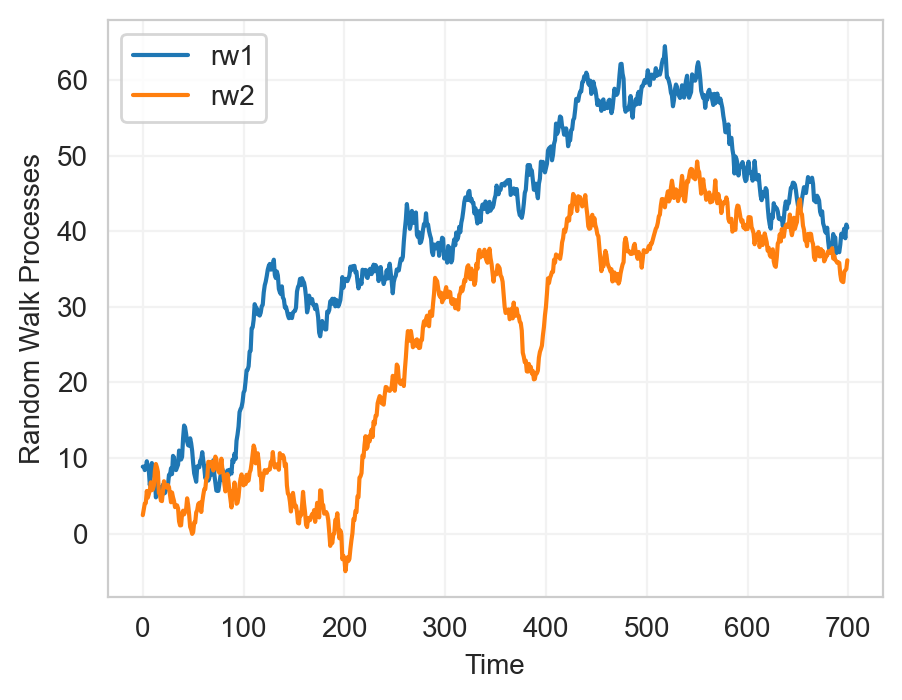

In [21]:
ax=sns.lineplot(x=spur.index,y=spur.rw1,label='rw1')
ax.set(xlabel='Time',ylabel='Random Walk Processes')
ax=sns.lineplot(x=spur.index,y=spur.rw2,label='rw2')
plt.legend();

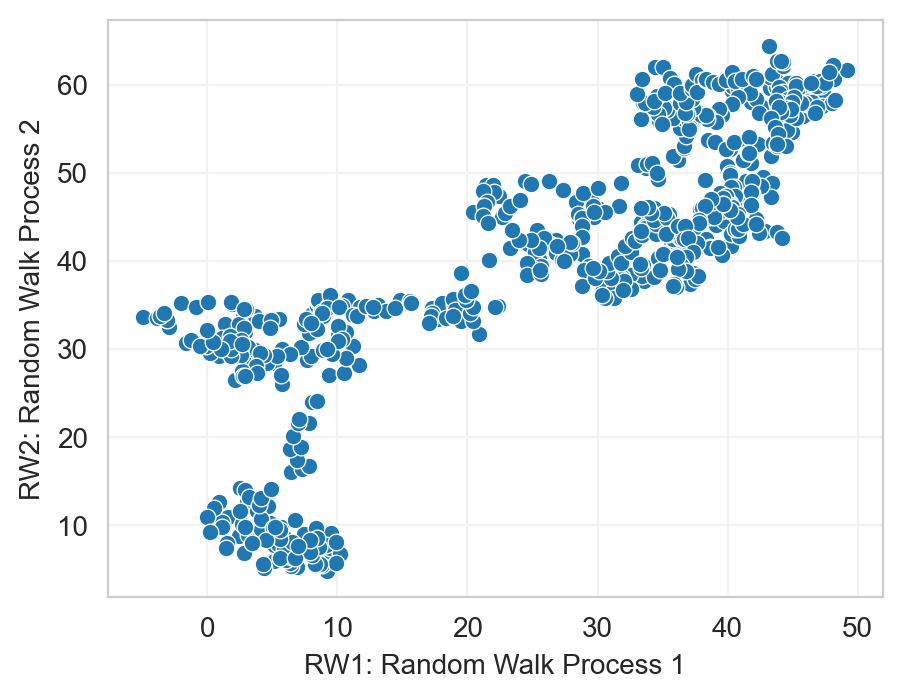

In [22]:
ax=sns.scatterplot(x=spur.rw2,y=spur.rw1)
ax.set(xlabel='RW1: Random Walk Process 1',ylabel='RW2: Random Walk Process 2');

In [23]:
res=smf.ols(formula='rw1~rw2',data=spur).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.8180      0.620     28.717      0.000      16.600      19.036
rw2            0.8420      0.021     40.837      0.000       0.802       0.883


In [24]:
lags=1
data=[
    ['lags (p)','chi2','df','Prob>chi2'],
    [lags,
     sm.stats.diagnostic.acorr_breusch_godfrey(res,nlags=lags)[0],
     res.df_model,
     sm.stats.diagnostic.acorr_breusch_godfrey(res,nlags=lags)[1]]
]
print('Breusch-Godfrey LM Test for Autocorrelation')
print('H0: no serial correlation','\n')
print(tabulate(data,headers='firstrow',colalign=('center','center','center','center'),
               floatfmt=('.1f','.2f','.1f','.3f')))

Breusch-Godfrey LM Test for Autocorrelation
H0: no serial correlation 

 lags (p)    chi2    df    Prob>chi2
----------  ------  ----  -----------
    1       682.96  1.0      0.000


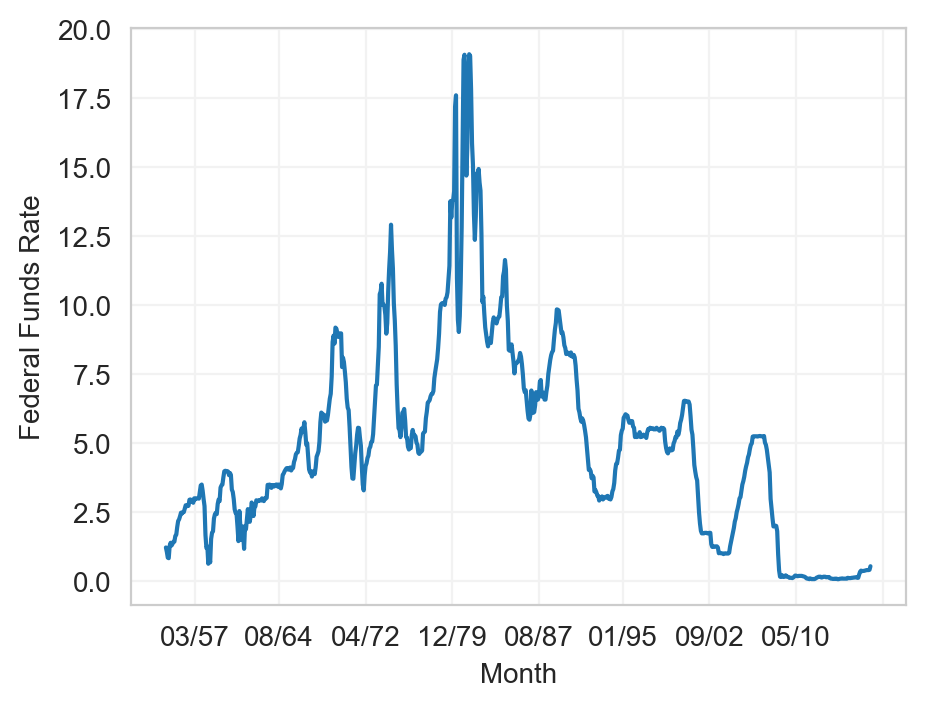

In [25]:
ax=sns.lineplot(x=usdat.index,y=usdat.ffr)
ax.set(xlabel='Month',ylabel='Federal Funds Rate')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     

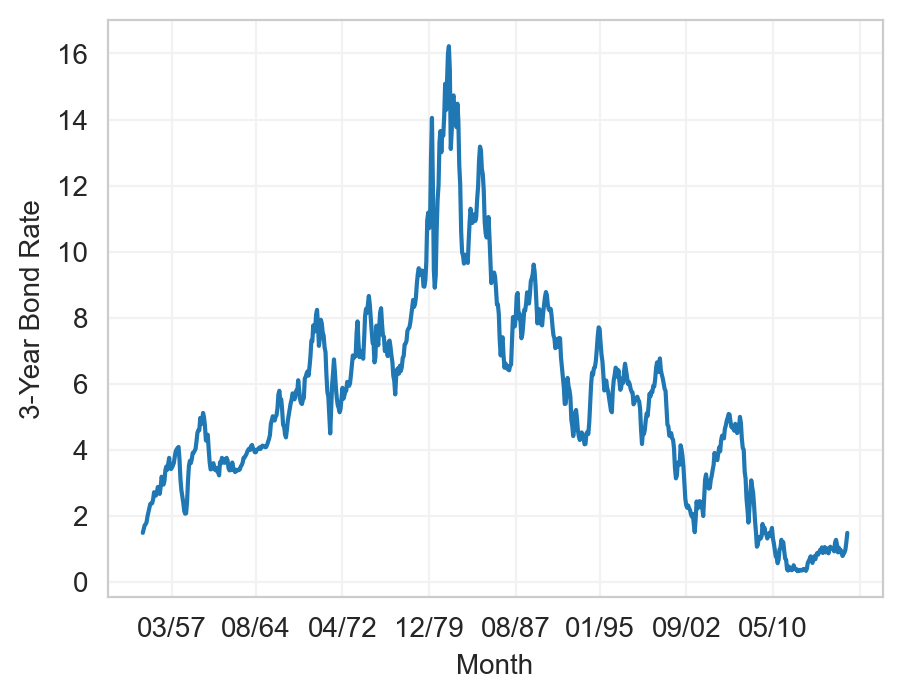

In [26]:
ax=sns.lineplot(x=usdat.index,y=usdat.br)
ax.set(xlabel='Month',ylabel='3-Year Bond Rate')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

In [27]:
usdat['D1ffr']=usdat['ffr'].diff(1)
usdat['L1ffr']=usdat['ffr'].shift(1)
usdat['D1L1ffr']=usdat['ffr'].diff(1).shift(1)
usdat['D1L2ffr']=usdat['ffr'].diff(1).shift(2)
res=smf.ols('D1ffr~L1ffr+D1L1ffr+D1L2ffr',data=usdat).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0580      0.029      1.999      0.046       0.001       0.115
L1ffr         -0.0118      0.005     -2.475      0.014      -0.021      -0.002
D1L1ffr        0.4443      0.036     12.301      0.000       0.373       0.515
D1L2ffr       -0.1471      0.036     -4.050      0.000      -0.218      -0.076


In [28]:
usdat['D1br']=usdat['br'].diff(1)
usdat['L1br']=usdat['br'].shift()
usdat['D1L1br']=usdat['br'].diff(1).shift(1)
usdat['D1L2br']=usdat['br'].diff(1).shift(2)
res=smf.ols('D1br~L1br+D1L1br+D1L2br+1',data=usdat).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0343      0.024      1.459      0.145      -0.012       0.081
L1br          -0.0064      0.004     -1.695      0.090      -0.014       0.001
D1L1br         0.4257      0.036     11.946      0.000       0.356       0.496
D1L2br        -0.2297      0.036     -6.425      0.000      -0.300      -0.160


In [29]:
resadf=adfuller(usdat.ffr,maxlag=2,regression='c',regresults='True')     
print('Augmented Dickey-Fuller Unit Root Test:')
print(f'Number of obs                     :     {res.nobs:.0f}' )
print(f'ADF Statistic                     :  {resadf[0]:.4}')
print(f'MacKinnon approx. p-value for Z(t):   {resadf[1]:.4}','\n')
print('Interpolated Dickey-Fuller Critical Values:')
for key, value in resadf[2].items():
    print('\t%s: %.3f' % (key,value))

Augmented Dickey-Fuller Unit Root Test:
Number of obs                     :     746
ADF Statistic                     :  -2.475
MacKinnon approx. p-value for Z(t):   0.1217 

Interpolated Dickey-Fuller Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [30]:
resadf=adfuller(usdat.br,maxlag=2,regression='c',regresults='True')
print('Augmented Dickey-Fuller Unit Root Test','\n')
print(f'Number of obs                     :     {res.nobs:.0f}' )
print(f'ADF Statistic                     :  {resadf[0]:.4}')
print(f'MacKinnon approx. p-value for Z(t):   {resadf[1]:.4}','\n')
print('Interpolated Dickey-Fuller Critical Values:')
for key, value in resadf[2].items():
    print('\t%s: %.3f' % (key,value))

Augmented Dickey-Fuller Unit Root Test 

Number of obs                     :     746
ADF Statistic                     :  -1.695
MacKinnon approx. p-value for Z(t):   0.4336 

Interpolated Dickey-Fuller Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [31]:
dfgls=DFGLS(usdat['ffr'],trend='ct',method='aic')
print(dfgls.summary())

      Dickey-Fuller GLS Results      
Test Statistic                 -2.166
P-value                         0.226
Lags                               17
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.44 (1%), -2.87 (5%), -2.59 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [32]:
dfgls=DFGLS(usdat.br,trend='ct',method='bic')
print(dfgls.summary())

      Dickey-Fuller GLS Results      
Test Statistic                 -1.165
P-value                         0.763
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.44 (1%), -2.87 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [33]:
respp1=PhillipsPerron(usdat.ffr,lags=6,test_type='rho')
print(respp1.summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                -10.578
P-value                         0.117
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -20.47 (1%), -14.02 (5%), -11.20 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [34]:
respp2=PhillipsPerron(usdat.ffr,lags=6,test_type='tau')
print(respp2.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.279
P-value                         0.179
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [35]:
respp3=PhillipsPerron(usdat.br,lags=6,test_type='rho')
print(respp3.summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                 -6.321
P-value                         0.324
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -20.47 (1%), -14.02 (5%), -11.20 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [36]:
respp4=PhillipsPerron(usdat.br,lags=6,test_type='tau')
print(respp4.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.778
P-value                         0.391
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [37]:
gdp=pd.read_csv(poe5csv+'gdp5.csv',parse_dates=['dateid01'])
gdp['date']=gdp['dateid01'].dt.strftime('%m/%y')
gdp=gdp.set_index('date')
gdp['D1gdp']=gdp['gdp'].diff(1)
gdp['L1gdp']=gdp['gdp'].shift(1)
gdp['D1L1gdp']=gdp['gdp'].diff(1).shift(1)
gdp['D1L2gdp']=gdp['gdp'].diff(1).shift(2)
gdp['t']=np.arange(0,132)
res=smf.ols('D1gdp~t+L1gdp+D1L1gdp+D1L2gdp',data=gdp).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2686      0.115      2.326      0.022       0.040       0.497
t              0.0025      0.001      1.970      0.051   -1.15e-05       0.005
L1gdp         -0.0330      0.017     -1.999      0.048      -0.066      -0.000
D1L1gdp        0.3115      0.087      3.576      0.000       0.139       0.484
D1L2gdp        0.2019      0.088      2.284      0.024       0.027       0.377


In [38]:
resadf=adfuller(gdp.gdp,regression='ct',autolag='BIC')
print(f'Test Statistics Z(t)                   = {resadf[0]:.3f}')
print(f'MacKinnon approximate p-value for Z(t) =  {resadf[1]:.4f}')
for key, value in resadf[4].items():
	print('\t%s: %.3f' % (key, value))

Test Statistics Z(t)                   = -1.999
MacKinnon approximate p-value for Z(t) =  0.6018
	1%: -4.031
	5%: -3.445
	10%: -3.147


In [39]:
tood['t']=np.arange(0,48)
tood['D1lny']=tood['lny'].diff()
tood['L1lny']=tood['lny'].shift()
res=smf.ols(formula='D1lny~t+L1lny',data=tood).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1575      0.078     -2.008      0.051      -0.316       0.001
t              0.0167      0.004      4.292      0.000       0.009       0.025
L1lny         -0.7453      0.142     -5.240      0.000      -1.032      -0.459


In [40]:
resadf=adfuller(tood.lny,maxlag=0,regression='ct')
print(f'Test Statistics Z(t)                   = {resadf[0]:.3f}')
print(f'MacKinnon approximate p-value for Z(t) =  {resadf[1]:.4f}')
for key, value in resadf[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistics Z(t)                   = -5.240
MacKinnon approximate p-value for Z(t) =  0.0001
	1%: -4.166
	5%: -3.508
	10%: -3.184


In [41]:
usdat=pd.read_csv(poe5csv+'usdata5.csv',parse_dates=['dateid01'])
usdat['date']=usdat['dateid01'].dt.strftime('%m/%y')
usdat=usdat.set_index('date')
usdat['D1ffr']=usdat.ffr.diff()
usdat=usdat.dropna() 
resadf=adfuller(usdat.D1ffr,maxlag=1,regression='n')
print(f'Test Statistics Z(t)                   = {resadf[0]:.3f}')
print(f'MacKinnon approximate p-value for Z(t) =   {resadf[1]:.3f}')
for key, value in resadf[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistics Z(t)                   = -17.761
MacKinnon approximate p-value for Z(t) =   0.000
	1%: -2.569
	5%: -1.941
	10%: -1.616


In [42]:
usdat=pd.read_csv(poe5csv+'usdata5.csv',parse_dates=['dateid01'])
usdat['date']=usdat['dateid01'].dt.strftime('%m/%y')
usdat=usdat.set_index('date')
usdat['D1br']=usdat.br.diff()
usdat=usdat.dropna() 
resadf=adfuller(usdat.D1br,maxlag=1,regression='n')
print(f'Test Statistics Z(t)                   = {resadf[0]:.3f}')
print(f'MacKinnon approximate p-value for Z(t) =   {resadf[1]:.4f}')
for key, value in resadf[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistics Z(t)                   = -19.837
MacKinnon approximate p-value for Z(t) =   0.0000
	1%: -2.569
	5%: -1.941
	10%: -1.616


In [43]:
res=smf.ols('br~ffr',data=usdat).fit()
usdat=usdat.dropna() 
usdat['ehat']=res.resid
usdat['D1ehat']=usdat['ehat'].diff(1)
usdat['L1ehat']=usdat['ehat'].shift(1)
usdat['D1L1ehat']=usdat['D1ehat'].shift(1)
usdat['D1L2ehat']=usdat['D1ehat'].shift(2)
usdat=usdat.dropna() 
res=smf.ols('D1ehat~L1ehat+D1L1ehat+D1L2ehat-1',data=usdat).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
L1ehat        -0.0817      0.015     -5.519      0.000      -0.111      -0.053
D1L1ehat       0.2233      0.036      6.277      0.000       0.153       0.293
D1L2ehat      -0.1771      0.036     -4.902      0.000      -0.248      -0.106


In [44]:
resadf=adfuller(usdat.ehat,maxlag=2,regression='n')
print(f'Test Statistics Z(t)                   = {resadf[0]:.3f}')
print(f'MacKinnon approximate p-value for Z(t) =  {resadf[1]:.4f}')
for key, value in resadf[4].items():
    print('\t%s: %.3f' % (key, value))

Test Statistics Z(t)                   = -5.513
MacKinnon approximate p-value for Z(t) =  0.0000
	1%: -2.569
	5%: -1.941
	10%: -1.616


In [45]:
usdat=pd.read_csv(poe5csv+'usdata5.csv',parse_dates=['dateid01'])
usdat['date']=usdat['dateid01'].dt.strftime('%m/%y')
usdat=usdat.set_index('date')
usdat=usdat[['br','ffr']]
D1br=usdat.br.diff(1).to_numpy(copy=True);D1br=np.delete(D1br[~np.isnan(D1br)],[0,1,2,3])
L1br=usdat.br.shift(1).to_numpy(copy=True);L1br=np.delete(L1br[~np.isnan(L1br)],[0,1,2,3]) 
L1D1br=usdat.br.diff(1).shift(1).to_numpy(copy=True)
L1D1br=np.delete(L1D1br[~np.isnan(L1D1br)],[0,1,2])
L2D1br=usdat.br.diff(1).shift(2).to_numpy(copy=True)
L2D1br=np.delete(L2D1br[~np.isnan(L2D1br)],[0,1])
L1ffr=usdat.ffr.shift(1).to_numpy(copy=True)
L1ffr=np.delete(L1ffr[~np.isnan(L1ffr)],[0,1,2,3])
D1ffr=usdat.ffr.diff(1).to_numpy(copy=True)
D1ffr=np.delete(D1ffr[~np.isnan(D1ffr)],[0,1,2,3])
L1D1ffr=usdat.ffr.diff(1).shift(1).to_numpy(copy=True)
L1D1ffr=np.delete(L1D1ffr[~np.isnan(L1D1ffr)],[0,1,2])
L2D1ffr=usdat.ffr.diff().shift(2).to_numpy(copy=True)
L2D1ffr=np.delete(L2D1ffr[~np.isnan(L2D1ffr)],[0,1])
L3D1ffr=usdat.ffr.diff().shift(3).to_numpy(copy=True)
L3D1ffr=np.delete(L3D1ffr[~np.isnan(L3D1ffr)],[0])
L4D1ffr=usdat.ffr.diff().shift(4).to_numpy(copy=True);L4D1ffr=L4D1ffr[~np.isnan(L4D1ffr)]

In [46]:
def func(params,D1br,L1br,L1D1br,L2D1br,L1ffr,D1ffr,L1D1ffr,L2D1ffr,L3D1ffr,L4D1ffr):
    a=params['a'];b1=params['b1'];b2=params['b2'];g1=params['g1'];g2=params['g2']
    d0=params['d0'];d1=params['d1'];d2=params['d2'];d3=params['d3'];d4=params['d4']
    model=-a*(L1br-b1-b2*L1ffr)+ \
    g1*L1D1br+g2*L2D1br+d0*D1ffr+d1*L1D1ffr+d2*L2D1ffr+d3*L3D1ffr+d4*L4D1ffr
    return(D1br-model)
params=Parameters()
params.add('a',value=0);params.add('b1',value=0);params.add('b2',value=0)
params.add('g1',value=0);params.add('g2',value=0)
params.add('d0',value=0);params.add('d1',value=0);params.add('d2',value=0)
params.add('d3',value=0);params.add('d4',value=0)
out=minimize(func,params,args=(D1br,L1br,L1D1br,L2D1br,L1ffr,D1ffr,L1D1ffr,L2D1ffr,
                               L3D1ffr,L4D1ffr))
report_fit(out,show_correl=False)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 744
    # variables        = 10
    chi-square         = 58.7206045
    reduced chi-square = 0.08000082
    Akaike info crit   = -1869.20226
    Bayesian info crit = -1823.08185
[[Variables]]
    a:   0.04638112 +/- 0.01188365 (25.62%) (init = 0)
    b1:  1.32333135 +/- 0.38596829 (29.17%) (init = 0)
    b2:  0.83297697 +/- 0.06348699 (7.62%) (init = 0)
    g1:  0.27236546 +/- 0.03745047 (13.75%) (init = 0)
    g2: -0.24210789 +/- 0.03783200 (15.63%) (init = 0)
    d0:  0.34178326 +/- 0.02404277 (7.03%) (init = 0)
    d1: -0.10532046 +/- 0.02751906 (26.13%) (init = 0)
    d2:  0.09905855 +/- 0.02733119 (27.59%) (init = 0)
    d3: -0.06597486 +/- 0.02449723 (37.13%) (init = 0)
    d4:  0.05604084 +/- 0.02281732 (40.72%) (init = 0)


In [47]:
theta1=1-out.params['a']
print(f'Theta1= {theta1:.6f}')

Theta1= 0.953619


In [48]:
ehat=L1br-out.params['b1']-out.params['b2']*L1ffr
data=pd.DataFrame()
data['ehat']=ehat.tolist()
data['D1ehat']=data['ehat'].diff(1)
data['L1ehat']=data['ehat'].shift(1)
data['L1D1ehat']=data['ehat'].diff(1).shift(1)
data['L2D1ehat']=data['ehat'].diff(1).shift(2)
res=smf.ols('D1ehat~L1ehat+L1D1ehat-1',data=data).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
L1ehat        -0.0995      0.015     -6.808      0.000      -0.128      -0.071
L1D1ehat       0.2053      0.036      5.704      0.000       0.135       0.276


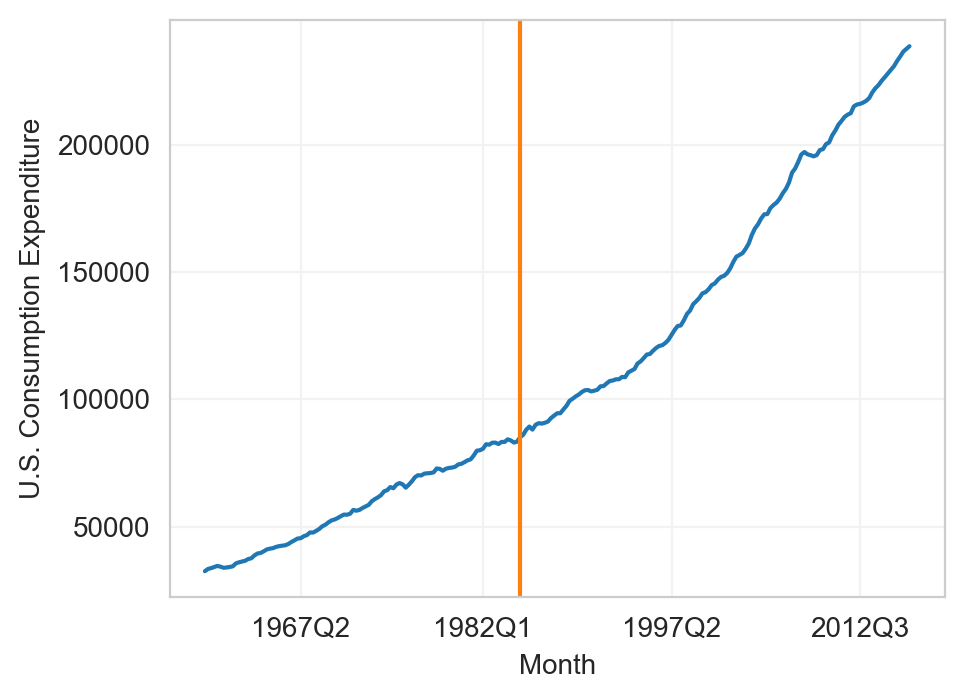

In [49]:
cons_inc=pd.read_csv(poe5csv+'cons_inc.csv',parse_dates=['dateid01'])
cons_inc['year']=cons_inc['dateid01'].dt.year
cons_inc['quarter']=cons_inc['dateid01'].dt.quarter
n=len(cons_inc.index)
s=[]
for i in range(n):
    val1=str(cons_inc.year[i])+'Q'+str(cons_inc.quarter[i])
    s.append(val1)
cons_inc['qtr_str']=s
cons_inc=cons_inc.set_index(cons_inc.qtr_str)
cons_inc['D1cons']=cons_inc.cons.diff(1)
cons_inc['L1cons']=cons_inc.cons.shift(1)
cons_inc['D1L1cons']=cons_inc.cons.diff(1).shift(1)
ax=sns.lineplot(x=cons_inc.index,y=cons_inc.cons)
ax.set(xlabel='Month',ylabel='U.S. Consumption Expenditure')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.axvline(x='1985Q1',color='tab:orange');

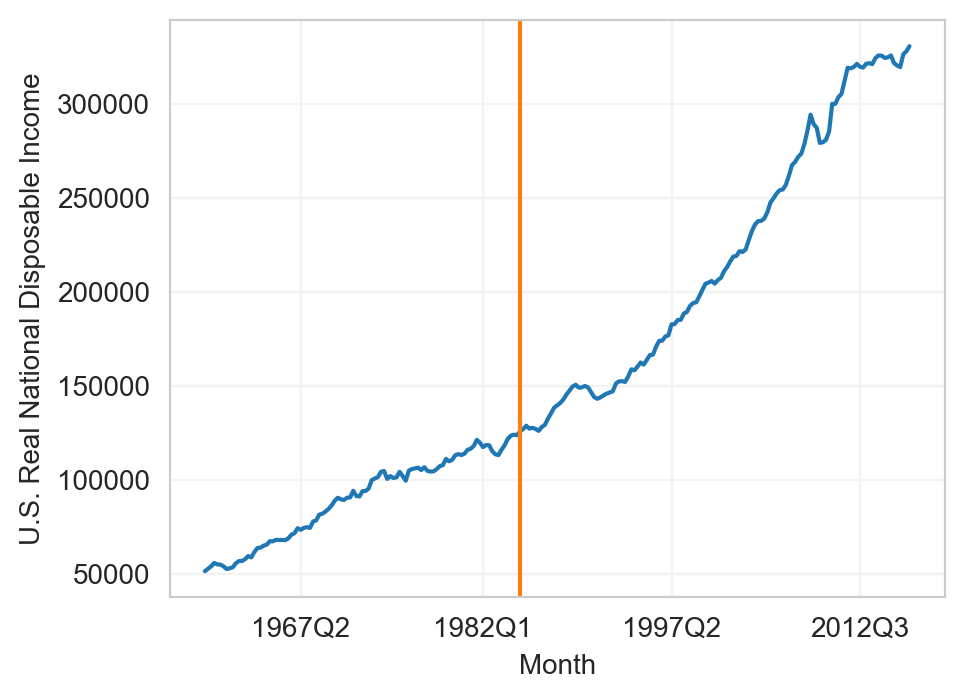

In [50]:
ax=sns.lineplot(x=cons_inc.index,y=cons_inc.y)
ax.set(xlabel='Month',ylabel='U.S. Real National Disposable Income')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.axvline(x='1985Q1',color='tab:orange');

In [51]:
res=smf.ols(formula='D1cons~t+L1cons+D1L1cons',data=cons_inc.iloc[102:,]).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1012.4881    734.451     -1.379      0.171   -2466.289     441.313
t             29.4330     14.533      2.025      0.045       0.666      58.200
L1cons        -0.0193      0.011     -1.702      0.091      -0.042       0.003
D1L1cons       0.2441      0.086      2.823      0.006       0.073       0.415


In [52]:
adf=ADF(cons_inc.cons.iloc[100:,],lags=1,trend='ct')
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.702
P-value                         0.750
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [53]:
adf=ADF(cons_inc.iloc[100:,3:4].values,lags=1,trend='ct')
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.143
P-value                         0.522
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.03 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [54]:
res=smf.ols(formula='cons~t+y',data=cons_inc.iloc[102:,]).fit()
cons_inc['ehat_c']=res.resid
cons_inc.iloc[101:102,-1]=1765.569
adf=ADF(cons_inc.ehat_c.iloc[101:,],lags=1,trend='n')
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.942
P-value                         0.003
Lags                                1
-------------------------------------

Trend: No Trend
Critical Values: -2.58 (1%), -1.94 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [55]:
adf=ADF(cons_inc.D1cons.iloc[101:,],trend='c',lags=0)
print(adf.summary())

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.140
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [56]:
cons_inc['D1y']=cons_inc.y.diff(1)
adf=ADF(cons_inc.D1y.iloc[101:,],trend='c',lags=0).regression
print(adf.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.7508      0.087     -8.680      0.000      -0.922      -0.580
const       1228.7472    267.130      4.600      0.000     700.064    1757.430


In [57]:
res=smf.ols(formula='D1cons~D1y+D1L1cons',data=cons_inc.iloc[102:,]).fit()
print(res.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                 D1cons   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.114
No. Observations:                 127   F-statistic:                     9.091
Covariance Type:            nonrobust   Prob (F-statistic):           0.000207
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    785.7726    127.640      6.156      0.000     533.137    1038.408
D1y            0.0573      0.028      2.072      0.040       0.003       0.112
D1L1cons       0.2825      0.085      3.336      0.001       0.115       0.450

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or ot